In [31]:
import numpy as np, pandas as pd
from matplotlib.pyplot import subplots
import matplotlib.pyplot as plt
import statsmodels.api as sm
from ISLP import load_data
from ISLP.models import (summarize,
                         poly,
                         ModelSpec as MS)
from statsmodels.stats.anova import anova_lm

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from pygam import (s as s_gam,
                   l as l_gam,
                   f as f_gam,
                   LinearGAM,
                   LogisticGAM)


from ISLP.transforms import (BSpline,
                             NaturalSpline)
from ISLP.models import bs, ns
from ISLP.pygam import (approx_lam,
                        degrees_of_freedom,
                        plot as plot_gam,
                        anova as anova_gam)

import sklearn.model_selection as skm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate

from ISLP.models import \
     (Stepwise,
      sklearn_selected,
      sklearn_selection_path)
from statsmodels.api import OLS
from functools import partial



### Problem 6

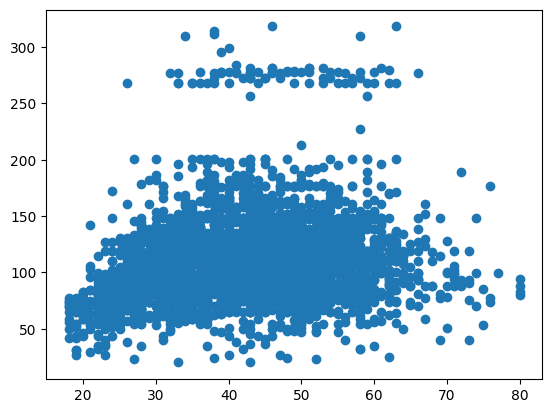

In [54]:
Wage = load_data("Wage")
plt.scatter(x = 'age', y = 'wage', data = Wage)

1593.9141039096162 3


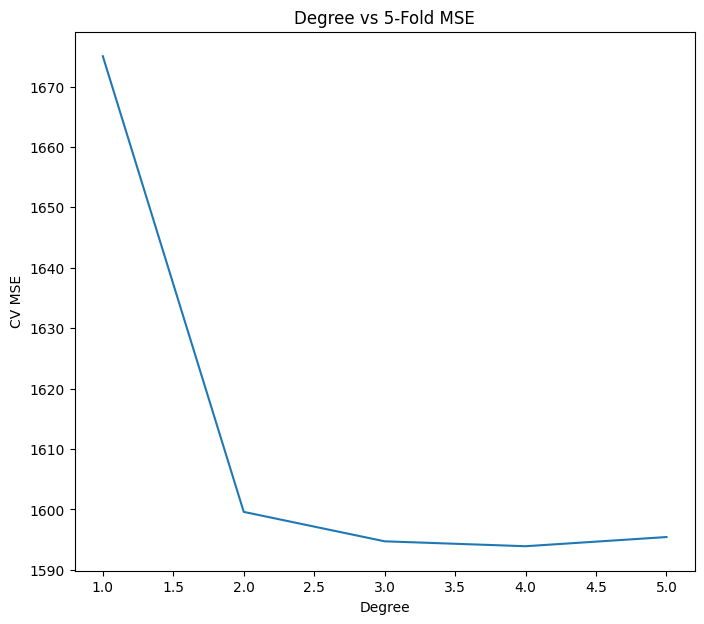

In [42]:
y = Wage['wage']
cv_mse_result = []
for i in range(1,6):
    poly_age = MS([poly('age', degree=i)]).fit(Wage)
    poly_age = poly_age.transform(Wage)
    model = LinearRegression(fit_intercept=False)
    dummy = (cross_validate(model, poly_age, y, scoring="neg_mean_squared_error", cv = 5, return_train_score=True))
    cv_mse_result.append(-dummy["test_score"].mean())


fig, ax = subplots(figsize = (8,7))
ax.plot(range(1,6), cv_mse_result)
ax.set_xlabel('Degree')
ax.set_ylabel("CV MSE")
ax.set_title("Degree vs 5-Fold MSE")
print(min(cv_mse_result), np.argmin(cv_mse_result))

In [43]:
models = [MS([poly('age', degree=d)]) 
          for d in range(1, 6)]
Xs = [model.fit_transform(Wage) for model in models]
anova_lm(*[sm.OLS(y, X_).fit()
           for X_ in Xs])

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,2998.0,5.022216e+06,0.0,NaN,NaN,NaN
1,2997.0,4.793430e+06,1.0,228786.010128,143.593107,2.363850e-32
2,2996.0,4.777674e+06,1.0,15755.693664,9.888756,1.679202e-03
3,2995.0,4.771604e+06,1.0,6070.152124,3.809813,5.104620e-02
4,2994.0,4.770322e+06,1.0,1282.563017,0.804976,3.696820e-01


Agreement because the p value versus the intercept only model is significant at the third degree

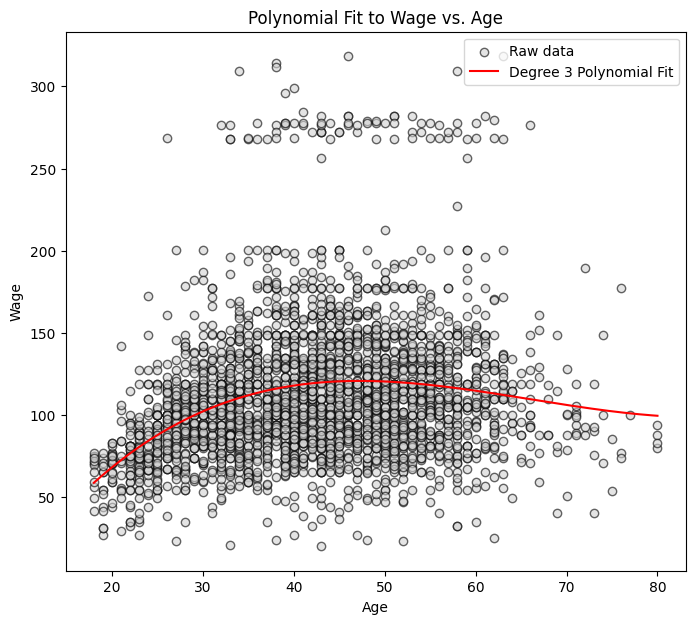

In [53]:
# Fit model on original Wage data
poly_spec = MS([poly('age', degree=3)]).fit(Wage)
X_poly = poly_spec.transform(Wage)
model = sm.OLS(y, sm.add_constant(X_poly)).fit()

# Create a new DataFrame for prediction
age_seq = np.linspace(Wage['age'].min(), Wage['age'].max(), 300)
Wage_grid = Wage.copy()
Wage_grid = Wage_grid.iloc[:300].copy()  # ensure it's the same shape
Wage_grid['age'] = age_seq

# Transform new data using the fitted poly_spec
X_new = poly_spec.transform(Wage_grid)
y_pred = model.predict(sm.add_constant(X_new))

# Plot
fig, ax = plt.subplots(figsize=(8, 7))
ax.scatter(Wage['age'], y, facecolor='lightgray', edgecolor='k', alpha=0.6, label='Raw data')
ax.plot(age_seq, y_pred, color='red', label='Degree 3 Polynomial Fit')
ax.set_xlabel('Age')
ax.set_ylabel("Wage")
ax.set_title("Polynomial Fit to Wage vs. Age")
ax.legend()
plt.show()

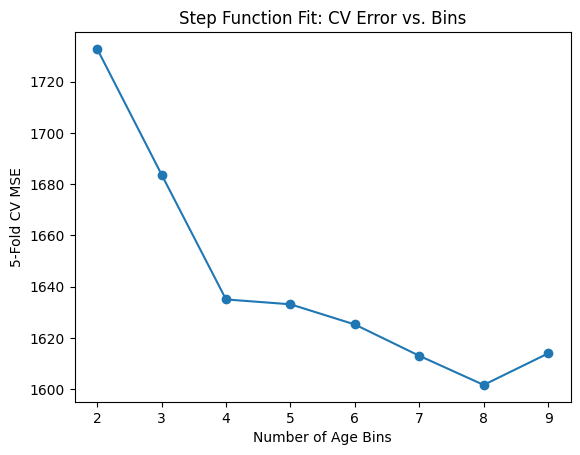

In [61]:
mse_cv = []
y = Wage['wage']
for i in range(2,10):
    Wage['age_bin'] = pd.cut(Wage['age'], bins = i)
    X = pd.get_dummies(Wage['age_bin'], drop_first=True)
    X.columns = X.columns.astype(str)
    X = sm.add_constant(X)
    model = LinearRegression()

    dummy = cross_validate(model, X, y, cv = 5, 
                           return_train_score=True, 
                           scoring = "neg_mean_squared_error")
    
    mse_cv.append(-dummy["test_score"].mean())


plt.plot(range(2, 10), mse_cv, marker='o')
plt.xlabel("Number of Age Bins")
plt.ylabel("5-Fold CV MSE")
plt.title("Step Function Fit: CV Error vs. Bins")
plt.show()

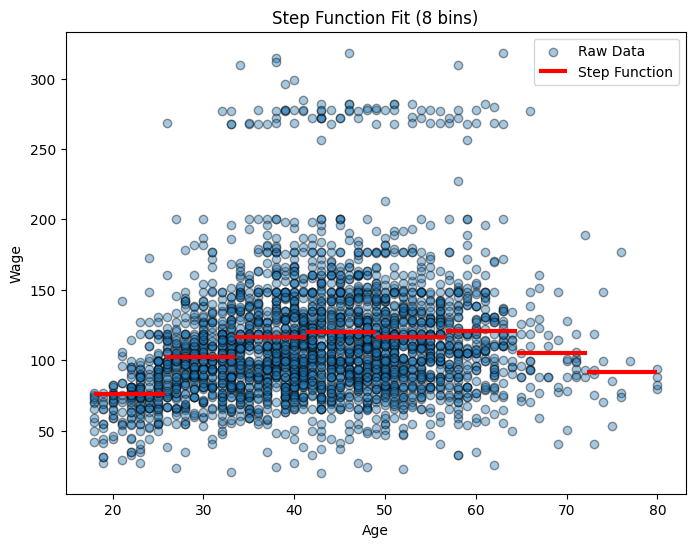

In [69]:
Wage['age_bin'] = pd.cut(Wage['age'], bins = 8)
X = pd.get_dummies(Wage['age_bin'], drop_first=True)
X.columns = X.columns.astype(str)
X = sm.add_constant(X)
model = LinearRegression().fit(X,y)
y_pred = model.predict(X)


fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(Wage['age'], y, alpha=0.4, label='Raw Data', edgecolor='k')

bin_means = pd.DataFrame({'age': Wage['age'], 'bin': Wage['age_bin'],'y_hat': y_pred})
bin_edges = Wage['age_bin'].cat.categories

for i, interval in enumerate(bin_edges):
    bin_mask = Wage['age_bin'] == interval
    y_val = y_pred[bin_mask].mean() 
    ax.hlines(y=y_val,
              xmin=interval.left,
              xmax=interval.right,
              colors='red', linewidth=3,
              label='Step Function' if i == 0 else None)
ax.set_xlabel("Age")
ax.set_ylabel("Wage")
ax.set_title("Step Function Fit (8 bins)")
ax.legend()
plt.show()


### Problem 9

In [115]:
Boston = load_data("Boston")
x = Boston['dis']
y = Boston['nox']


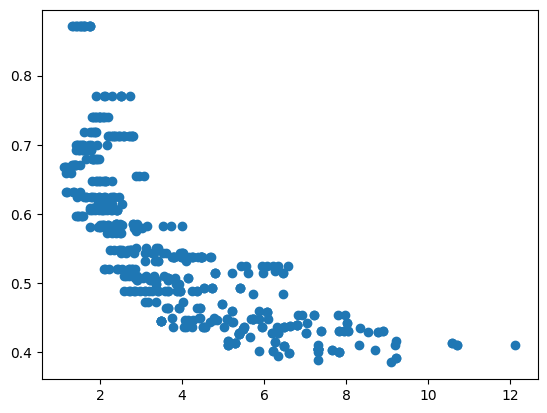

In [117]:
plt.scatter(x,y)

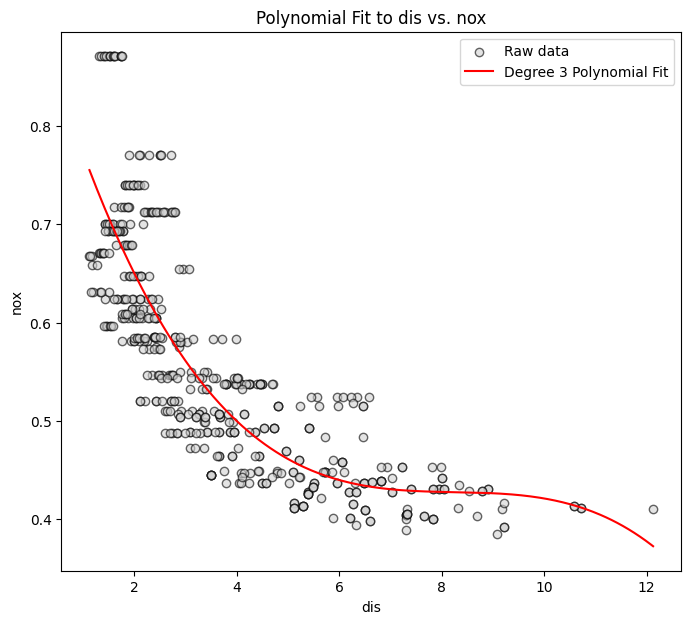

In [78]:
poly_x= MS([poly('dis', degree = 3)]).fit(Boston)
cub_poly = poly_x.transform(Boston)
model = LinearRegression(fit_intercept=True).fit(cub_poly, y)

new_x = np.linspace(x.min(), x.max(), 300) 
copy= Boston.copy() 
dis_grid = copy.iloc[:300].copy()
dis_grid["dis"] = new_x
x_trans = poly_x.transform(dis_grid)
y_pred = model.predict(x_trans)


fig, ax = plt.subplots(figsize=(8, 7))
ax.scatter(x, y, facecolor='lightgray', edgecolor='k', alpha=0.6, label='Raw data')
ax.plot(new_x, y_pred, color='red', label='Degree 3 Polynomial Fit')
ax.set_xlabel('dis')
ax.set_ylabel("nox")
ax.set_title("Polynomial Fit to dis vs. nox")
ax.legend()
plt.show()


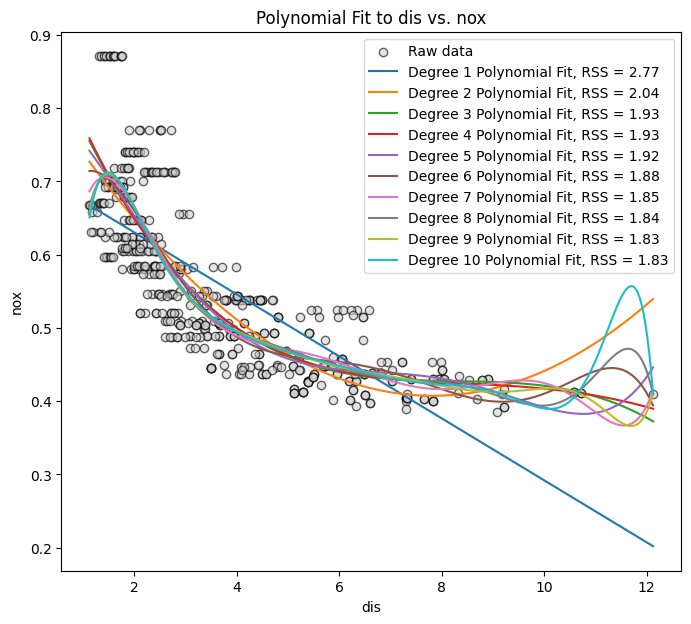

In [85]:
fig, ax = plt.subplots(figsize=(8, 7))
ax.scatter(x, y, facecolor='lightgray', edgecolor='k', alpha=0.6, label='Raw data')

rss = [] 

for i in range(1,11):
    poly_x= MS([poly('dis', degree = i)]).fit(Boston)
    cub_poly = poly_x.transform(Boston)
    model = LinearRegression(fit_intercept=True).fit(cub_poly, y)
    y_hat = model.predict(cub_poly)
    dummy = np.sum((y-y_hat)**2)
    rss.append(dummy)

    new_x = np.linspace(x.min(), x.max(), 300) 
    copy= Boston.copy() 
    dis_grid = copy.iloc[:300].copy()
    dis_grid["dis"] = new_x
    x_trans = poly_x.transform(dis_grid)
    y_pred = model.predict(x_trans)
    ax.plot(new_x, y_pred, label=f'Degree {i} Polynomial Fit, RSS = {dummy:.2f}')
    

ax.set_xlabel('dis')
ax.set_ylabel("nox")
ax.set_title("Polynomial Fit to dis vs. nox")
ax.legend()
plt.show()




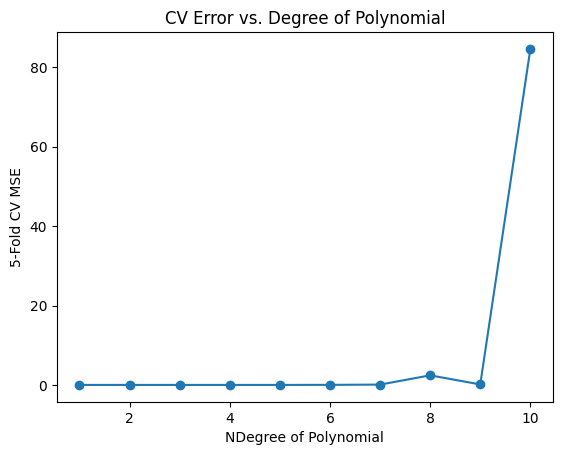

In [90]:
cv_mse = []
for i in range(1,11):
    poly_x= MS([poly('dis', degree = i)]).fit(Boston)
    cub_poly = poly_x.transform(Boston)
    model = LinearRegression(fit_intercept=True)
    cv = cross_validate(model, cub_poly, y, scoring="neg_mean_squared_error", return_train_score=True, cv = 5)
    cv_mse.append(-cv["test_score"].mean())


    
plt.plot(range(1, 11), cv_mse, marker='o')
plt.xlabel("NDegree of Polynomial")
plt.ylabel("5-Fold CV MSE")
plt.title("CV Error vs. Degree of Polynomial")
plt.show()

In [ ]:
#default degree = 3 
# internal knots = df - degree
bs_spec = MS([bs('dis', df = 4)]).fit(Boston)
bs_dis = bs_spec.transform(Boston)
model = sm.OLS(y, sm.add_constant(bs_dis)).fit()
summarize(model)

,coef,std err,t,P>|t|
intercept,0.7345,0.015,50.306,0.000
"bs(dis, df=4)[0]",-0.0581,0.022,-2.658,0.008
"bs(dis, df=4)[1]",-0.4636,0.024,-19.596,0.000
"bs(dis, df=4)[2]",-0.1998,0.043,-4.634,0.000
"bs(dis, df=4)[3]",-0.3888,0.046,-8.544,0.000


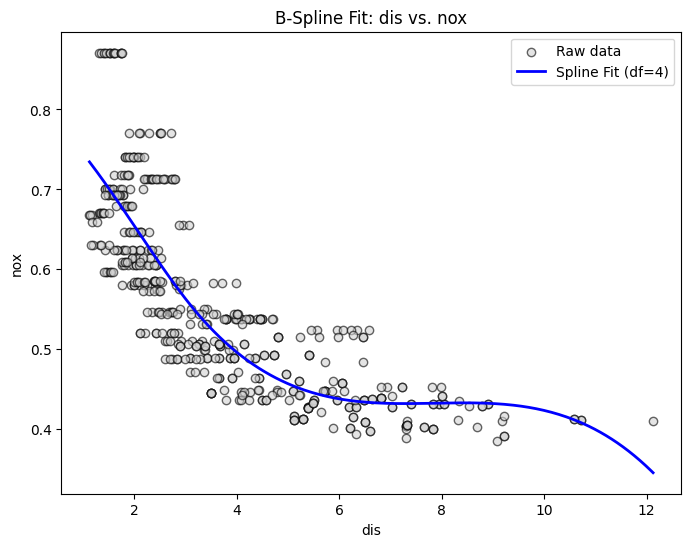

In [114]:
x_grid = np.linspace(x.min(), x.max(), 300)

# Create a new DataFrame to match ModelSpec input
grid_df = Boston.copy().iloc[:300].copy()
grid_df['dis'] = x_grid

# Transform the grid using the same spline basis
X_grid_bs = bs_spec.transform(grid_df)

# Predict using the fitted model
y_pred = model.predict(sm.add_constant(X_grid_bs))
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(x, y, facecolor='lightgray', edgecolor='k', alpha=0.6, label='Raw data')
ax.plot(x_grid, y_pred, color='blue', linewidth=2, label='Spline Fit (df=4)')
ax.set_xlabel('dis')
ax.set_ylabel('nox')
ax.set_title('B-Spline Fit: dis vs. nox')
ax.legend()
plt.show()

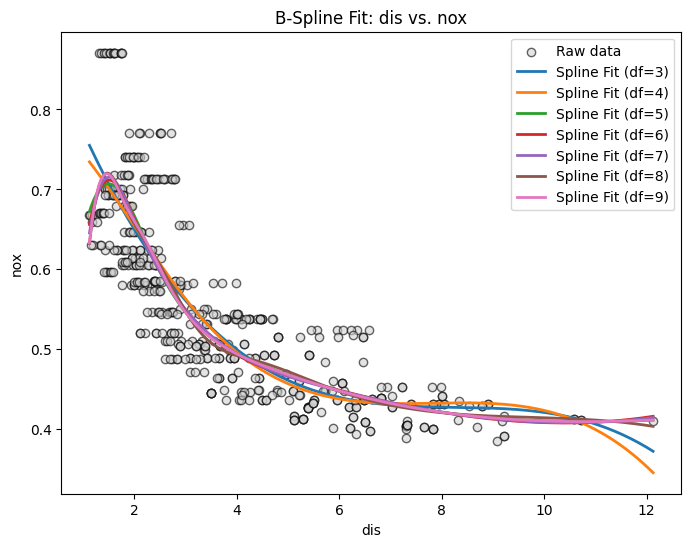

3


In [125]:
mss = []
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(x, y, facecolor='lightgray', edgecolor='k', alpha=0.6, label='Raw data')

for i in range(3,10): 
    bs_spec = MS([bs('dis', df = i)]).fit(Boston)
    bs_dis = bs_spec.transform(Boston)
    model = LinearRegression(fit_intercept=True)

    cv = cross_validate(model, bs_dis, y, scoring="neg_mean_squared_error", return_train_score=True, cv = 5)
    mss.append(-cv["test_score"].mean())

    model = sm.OLS(y, sm.add_constant(bs_dis)).fit()
    x_grid = np.linspace(x.min(), x.max(), 300)

    # Create a new DataFrame to match ModelSpec input
    grid_df = Boston.copy().iloc[:300].copy()
    grid_df['dis'] = x_grid

    # Transform the grid using the same spline basis
    X_grid_bs = bs_spec.transform(grid_df)

    # Predict using the fitted model
    y_pred = model.predict(sm.add_constant(X_grid_bs))
    ax.plot(x_grid, y_pred, linewidth=2, label=f'Spline Fit (df={i})')

ax.set_xlabel('dis')
ax.set_ylabel('nox')
ax.set_title('B-Spline Fit: dis vs. nox')
ax.legend()
plt.show()
print(np.argmin(mss) +3 )


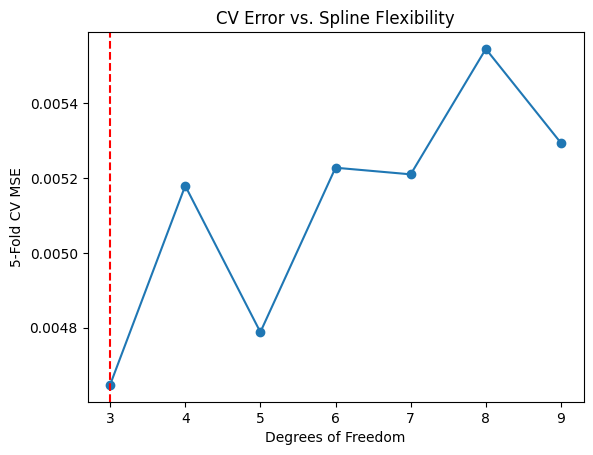

In [127]:
best_df = np.argmin(mss) + 3

plt.figure()
plt.plot(range(3, 10), mss, marker='o')
plt.axvline(best_df, color='red', linestyle='--', label='Best df')

plt.xlabel("Degrees of Freedom")
plt.ylabel("5-Fold CV MSE")
plt.title("CV Error vs. Spline Flexibility")
plt.show()



### Problem 10

In [4]:
College = load_data("College")
College.columns

Index(['Private', 'Apps', 'Accept', 'Enroll', 'Top10perc', 'Top25perc',
       'F.Undergrad', 'P.Undergrad', 'Outstate', 'Room.Board', 'Books',
       'Personal', 'PhD', 'Terminal', 'S.F.Ratio', 'perc.alumni', 'Expend',
       'Grad.Rate'],
      dtype='object')

In [5]:
College['Private'] = College['Private'].astype('category')
X_cols = College.columns.drop("Outstate")
full_design = MS(X_cols).fit(College)
X_final = full_design.transform(College)
design = MS(X_final.columns.tolist()).fit(X_final)
Y = College["Outstate"]

split = skm.ShuffleSplit(n_splits=1, 
                               test_size=0.25,
                               random_state=42)

for train_index, test_index in split.split(X_final):
    X_train, X_test = X_final.iloc[train_index], X_final.iloc[test_index]
    Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index]

In [6]:
def nCp(sigma2, estimator, X, Y):
    "Negative Cp statistic"
    n, p = X.shape
    Yhat = estimator.predict(X)
    RSS = np.sum((Y - Yhat)**2)
    return -(RSS + 2 * p * sigma2) / n 

sigma2 = OLS(Y_train, X_train).fit().scale
neg_CP = partial(nCp, sigma2)


In [7]:
strategy = Stepwise.first_peak(design,
                               direction='forward',
                               max_terms=len(design.terms))

fwd_MSE = sklearn_selected(OLS, strategy, scoring = neg_CP)
fwd_MSE.fit(X_train, Y_train)
selected = fwd_MSE.selected_state_
Xgam = X_train[list(selected)]
terms = (
    s_gam(0) + 
    s_gam(1) +
    s_gam(2) +
    s_gam(3) +
    s_gam(4) +
    s_gam(5) + 
    l_gam(6) +    
    s_gam(7) +
    s_gam(8) +
    s_gam(9) +                                         
    s_gam(10) +
    s_gam(11) 
)

# Fit the model
gam_full = LinearGAM(terms).fit(Xgam.values, Y_train)

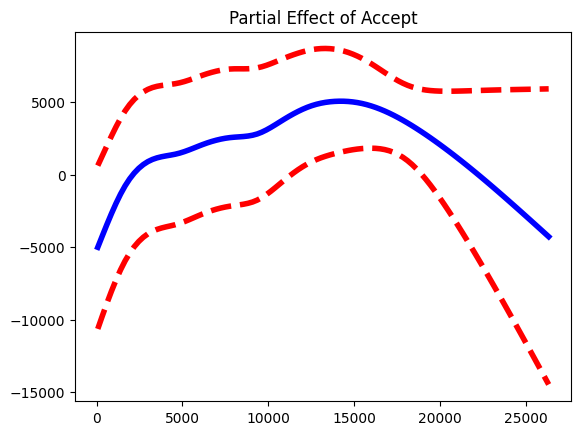

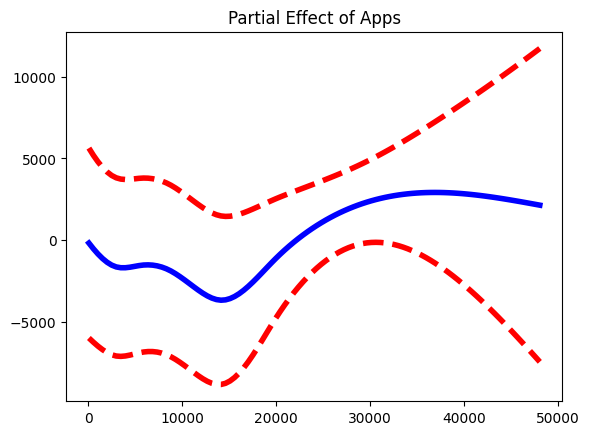

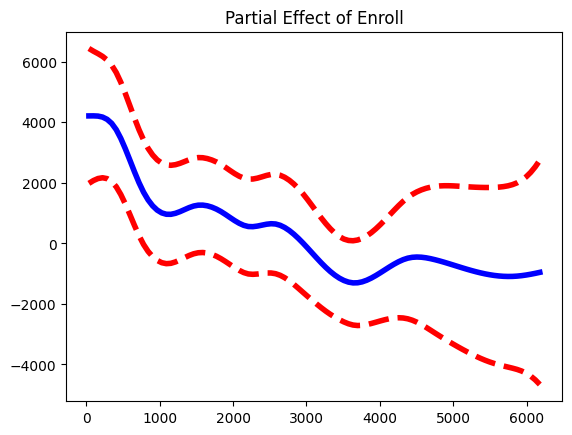

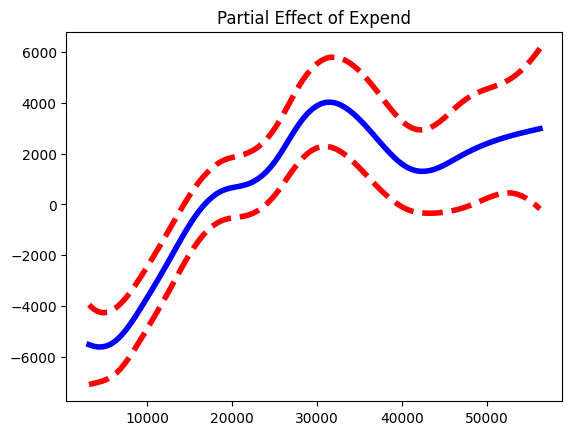

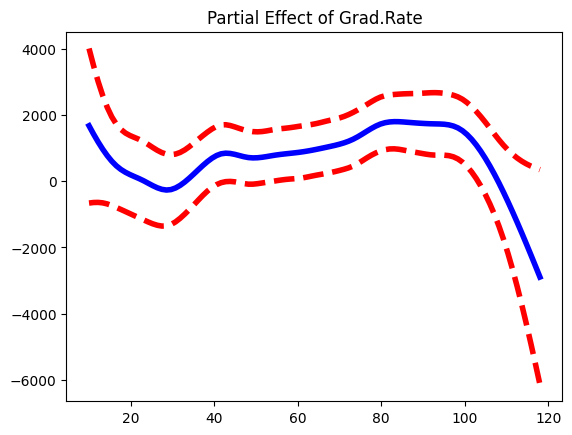

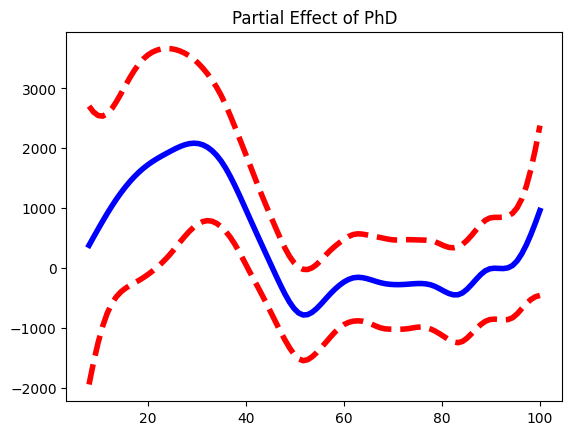

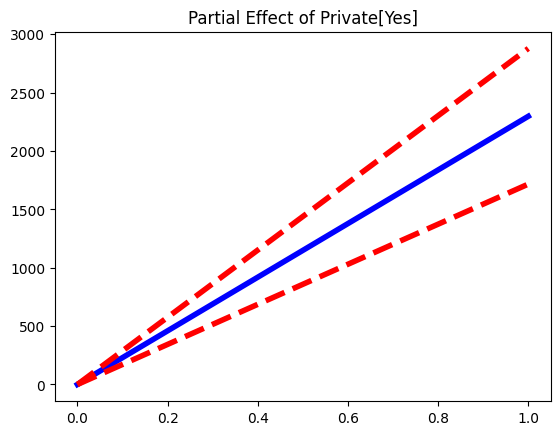

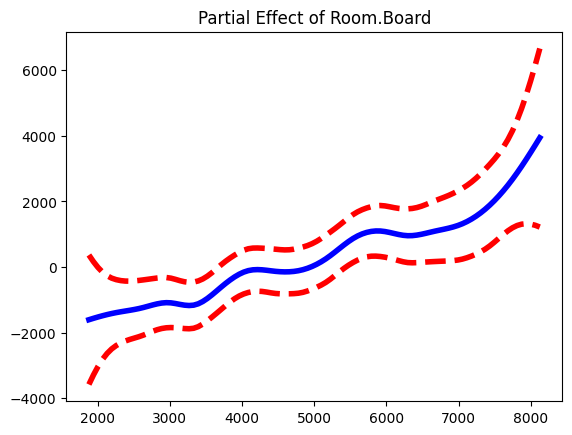

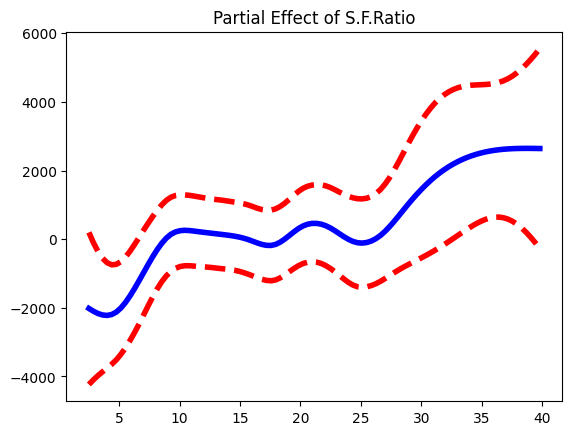

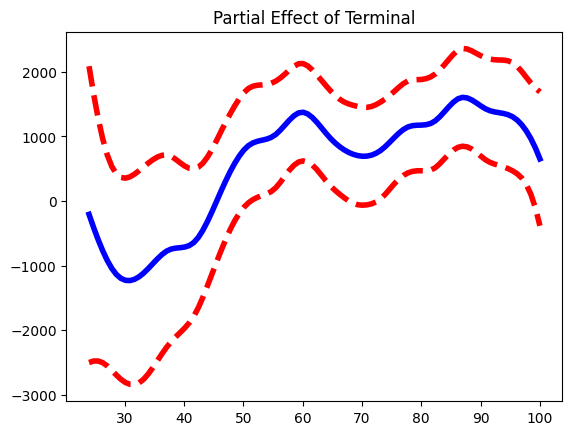

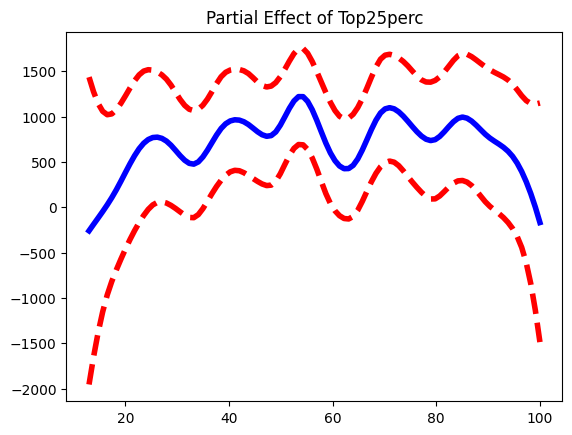

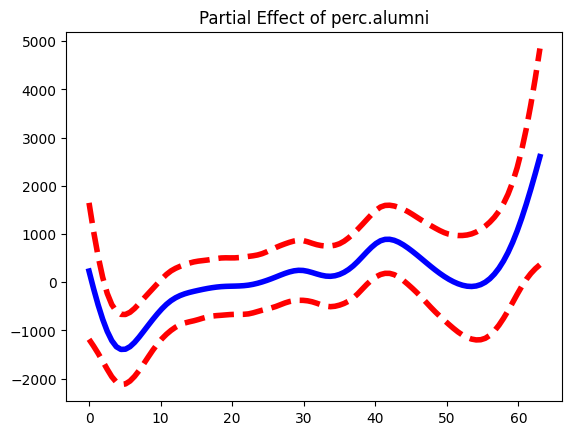

In [18]:
for i in range(len(terms)):
    if gam_full.terms[i].isintercept:
        continue  # skip intercept
    plt.figure()
    plot_gam(gam_full, i)
    plt.title(f"Partial Effect of {Xgam.columns[i]}")
    plt.show()

In [19]:
gam_full.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                    103.7946
Link Function:                     IdentityLink Log Likelihood:                                 -9187.9042
Number of Samples:                          582 AIC:                                            18585.3976
                                                AICc:                                           18631.9603
                                                GCV:                                          4180381.8213
                                                Scale:                                        2864310.5628
                                                Pseudo R-Squared:                                    0.849
Feature Function                  Lam

C:\Users\campz\AppData\Local\Temp\ipykernel_34888\3870570873.py:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam_full.summary()


In [ ]:
y_preds = gam_full.predict(X_test[list(selected)])

test_mse = mean_squared_error(Y_test, y_preds)
test_mse

3585463.0837815297

In [ ]:

gam = LinearGAM(terms)

lams = np.logspace(-4, 4, 100)  # Try 10 values from 1e-3 to 1e3

# Step 4: Tune using CV on training data
gam_tuned = gam.gridsearch(Xgam.values, Y_train, lam=lams)

  0% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--
  1% (1 of 100) |                        | Elapsed Time: 0:00:00 ETA:   0:01:03
  2% (2 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:00:56
  3% (3 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:00:54
  4% (4 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:00:52
  5% (5 of 100) |#                       | Elapsed Time: 0:00:02 ETA:   0:00:51
  6% (6 of 100) |#                       | Elapsed Time: 0:00:03 ETA:   0:00:50
  7% (7 of 100) |#                       | Elapsed Time: 0:00:03 ETA:   0:00:49
  8% (8 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:00:48
  9% (9 of 100) |##                      | Elapsed Time: 0:00:04 ETA:   0:00:47
 10% (10 of 100) |##                     | Elapsed Time: 0:00:05 ETA:   0:00:47
 11% (11 of 100) |##                     | Elapsed Time: 0:00:05 ETA:   0:00:46
 12% (12 of 100) |##                    

In [37]:
gam_tuned.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     54.5366
Link Function:                     IdentityLink Log Likelihood:                                 -9247.3192
Number of Samples:                          582 AIC:                                            18605.7114
                                                AICc:                                           18617.6622
                                                GCV:                                          3808670.5258
                                                Scale:                                        3172167.1423
                                                Pseudo R-Squared:                                   0.8155
Feature Function                  Lam

C:\Users\campz\AppData\Local\Temp\ipykernel_34888\1739244358.py:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam_tuned.summary()


Seems like s5, s8-10 might be linear not non linear since the p values are more than 0.05 

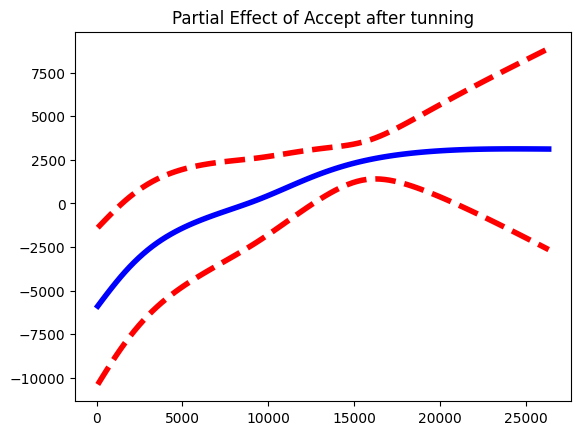

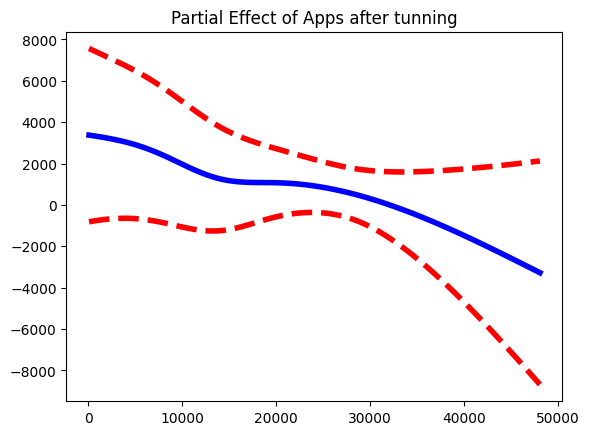

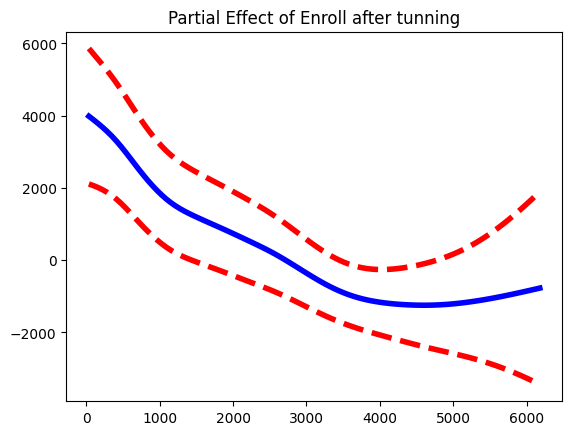

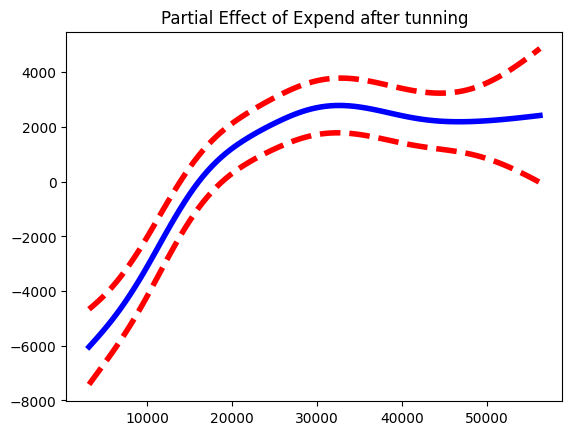

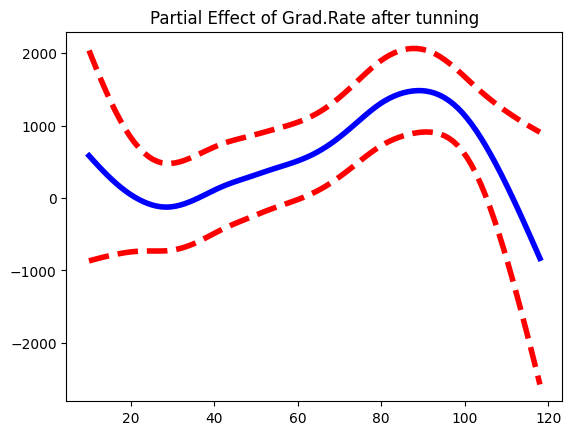

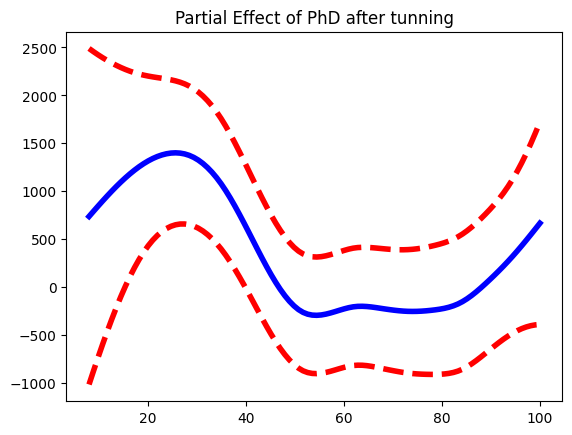

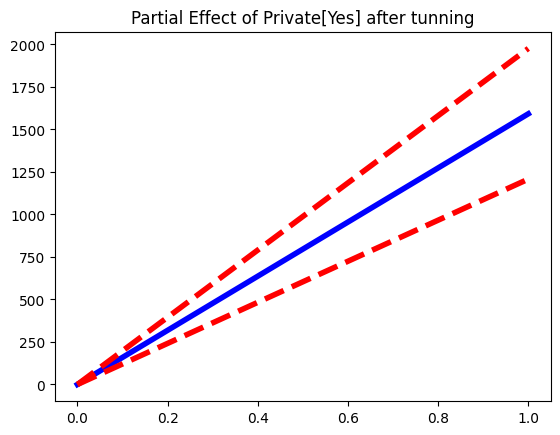

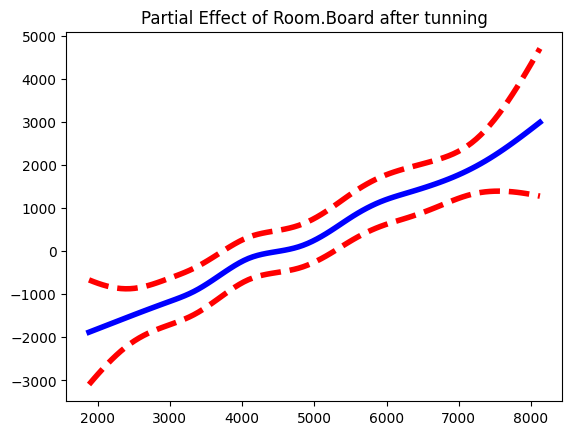

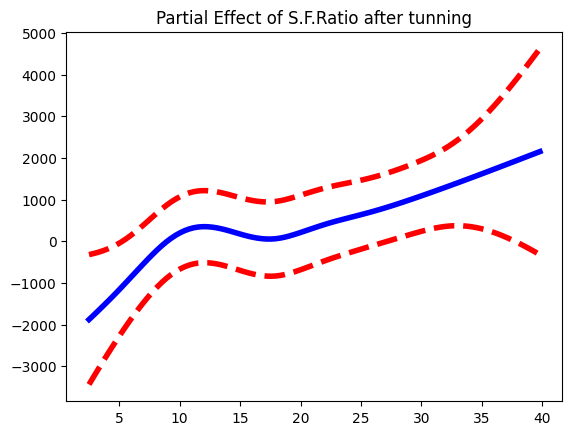

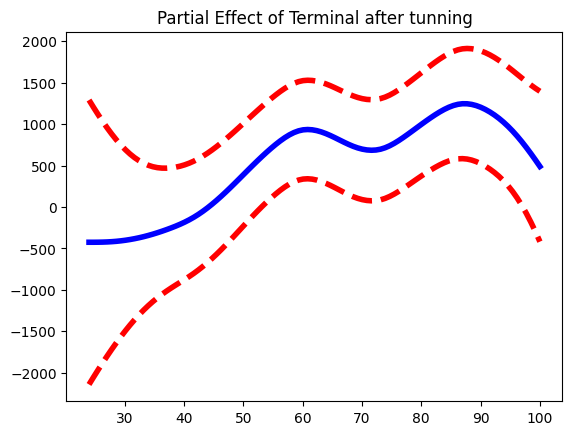

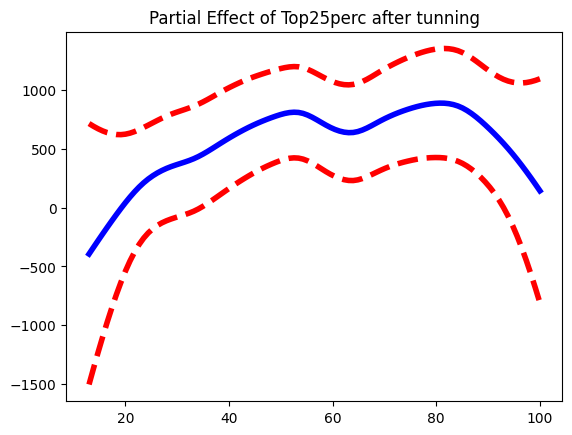

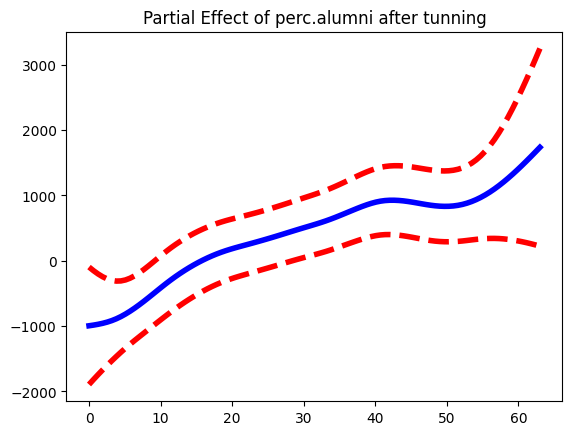

In [28]:
for i in range(len(terms)):
    if gam_tuned.terms[i].isintercept:
        continue  # skip intercept
    plt.figure()
    plot_gam(gam_tuned, i)
    plt.title(f"Partial Effect of {Xgam.columns[i]} after tunning")
    plt.show()

In [35]:
y_preds = gam_tuned.predict(X_test[list(selected)])

test_mse_tuned = mean_squared_error(Y_test, y_preds)
test_mse_tuned

3426694.952851522

In [36]:
test_mse - test_mse_tuned

158768.1309300079

### Problem 11

In [ ]:
np.random.seed(42)
Y = np.random.normal(-100,100, size = 100)
X1 = np.random.normal(-50,60, size = 100)
X2 = np.random.normal(5,200, size = 100)
beta1 = 1.5

array([  76.55747207,  117.15690527,  221.61024864,  215.76041041,
       -270.53387359, -182.56500798,  108.00705344,  107.75719018,
        108.00953726,  775.54629813,  119.17810214,  232.11312804,
        195.8003527 ,  135.27825026,  -58.05384893,  156.7938441 ,
       -149.56504291,  -42.36372135,  -92.07270957,   21.37482788,
        467.93171333, -368.45303852,  142.25203807, -317.54317424,
        -89.38637316,  222.79011939,   17.85600382, -210.54895559,
       -138.06074185,  140.91954979, -141.07332634,   48.29171792,
         14.11436798, -125.32006952,  433.78881787,  131.78380446,
       -400.02851733,   42.29086295, -127.35729295,  175.48666696,
       -153.50414769,  -17.94728829,  105.9974558 ,  178.15103883,
       -235.05928141,  -61.90024717,  -89.98906223, -125.66584651,
        358.09084806,   85.99634219, -247.17679087,  188.57238941,
        429.4312394 ,  211.49305211, -298.87399319,  -91.84681457,
        258.38222984, -136.53389312,   93.76388563,  159.92681

In [55]:
def simple_reg(outcome, feature):
    outcome = np.asarray(outcome).reshape(-1, 1)
    feature = np.asarray(feature).reshape(-1, 1)
    
    model = LinearRegression(fit_intercept=True).fit(feature, outcome)
    return model.intercept_[0], model.coef_[0][0]



In [56]:
outcome  = (Y-beta1*X1)
B0, B2 = simple_reg(outcome, X2)

In [57]:
outcome  = (Y-B2*X2)
B0, beta1 = simple_reg(outcome, X1)

B1: -0.20341401558102792, B2: 0.09441995748108188, intercept: -121.98072866048926
B1: -0.2056998009506544, B2: 0.07795524558001583, intercept: -121.7959357373885
B1: -0.2057028682112899, B2: 0.0779331518334373, intercept: -121.7956877665745
B1: -0.20570287232720033, B2: 0.07793312218617468, intercept: -121.79568743382625
B1: -0.2057028723327234, B2: 0.07793312214639149, intercept: -121.79568743337971
B1: -0.20570287233273082, B2: 0.07793312214633806, intercept: -121.7956874333791
B1: -0.2057028723327309, B2: 0.07793312214633802, intercept: -121.7956874333791
B1: -0.2057028723327309, B2: 0.077933122146338, intercept: -121.7956874333791
B1: -0.2057028723327309, B2: 0.077933122146338, intercept: -121.7956874333791
B1: -0.2057028723327309, B2: 0.077933122146338, intercept: -121.7956874333791
B1: -0.2057028723327309, B2: 0.077933122146338, intercept: -121.7956874333791
B1: -0.2057028723327309, B2: 0.077933122146338, intercept: -121.7956874333791
B1: -0.2057028723327309, B2: 0.07793312214633

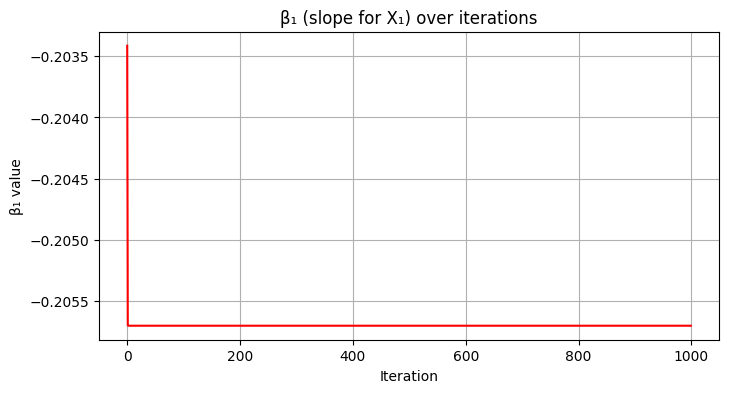

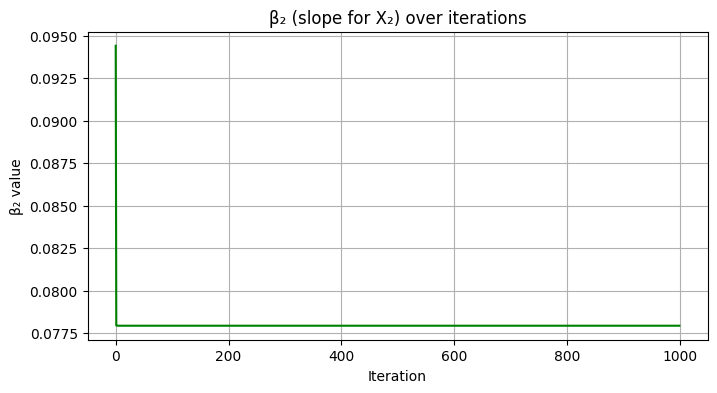

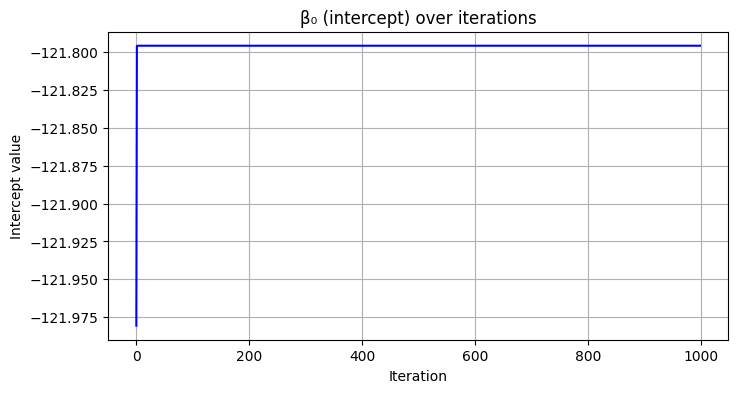

In [ ]:
beta1 = 1.5 
B1_hold = []
B0_hold = []
B2_hold= []
for _ in range(1000):
    outcome1  = (Y-beta1*X1)
    B0, B2 = simple_reg(outcome1, X2)
    outcome2  = (Y-B2*X2)
    B0, beta1 = simple_reg(outcome2, X1)

    B1_hold.append(beta1)
    B0_hold.append(B0)
    B2_hold.append(B2)

    print(f"B1: {beta1}, B2: {B2}, intercept: {B0}")





In [ ]:
X = np.column_stack((X1,X2))
mlr = LinearRegression(fit_intercept = True).fit(X,Y)
print("Intercept:", mlr.intercept_)
print("Coefficients:", mlr.coef_)

Intercept: -121.7956874333791
Coefficients: [-0.20570287  0.07793312]


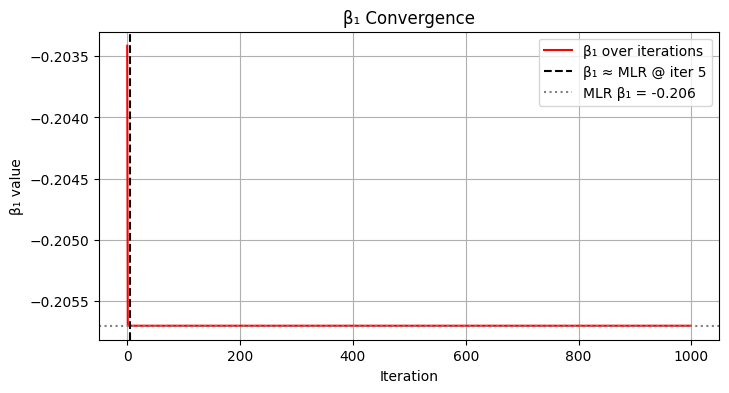

In [71]:
beta1_mlr = mlr.coef_[0]

# Find the iteration where β₁_hold is closest to the MLR β₁
closest_idx = np.argmin(np.abs(np.array(B1_hold) - beta1_mlr))

# Plot the coefficient evolution
plt.figure(figsize=(8, 4))
plt.plot(B1_hold, color='red', label='β₁ over iterations')
plt.axvline(x=closest_idx, color='k', linestyle='--', label=f'β₁ ≈ MLR @ iter {closest_idx}')
plt.axhline(y=beta1_mlr, color='gray', linestyle=':', label=f'MLR β₁ = {beta1_mlr:.3f}')
plt.xlabel("Iteration")
plt.ylabel("β₁ value")
plt.legend()
plt.title("β₁ Convergence")
plt.grid(True)
plt.show()


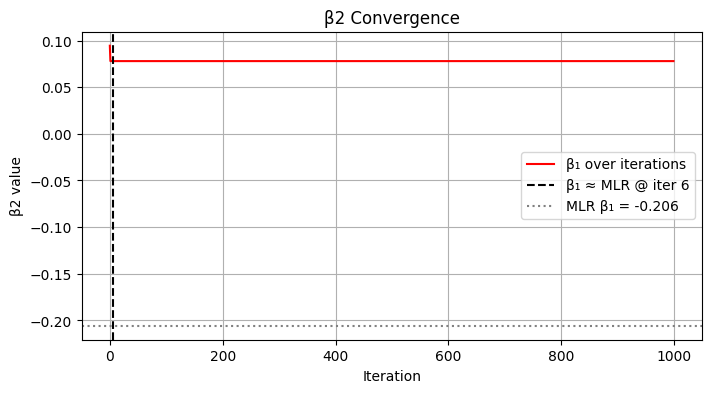

In [73]:
beta2_mlr = mlr.coef_[0]

# Find the iteration where β₁_hold is closest to the MLR β₁
closest_idx = np.argmin(np.abs(np.array(B2_hold) - beta2_mlr))

# Plot the coefficient evolution
plt.figure(figsize=(8, 4))
plt.plot(B2_hold, color='red', label='β₁ over iterations')
plt.axvline(x=closest_idx, color='k', linestyle='--', label=f'β₁ ≈ MLR @ iter {closest_idx}')
plt.axhline(y=beta2_mlr, color='gray', linestyle=':', label=f'MLR β₁ = {beta2_mlr:.3f}')
plt.xlabel("Iteration")
plt.ylabel("β2 value")
plt.legend()
plt.title("β2 Convergence")
plt.grid(True)
plt.show()

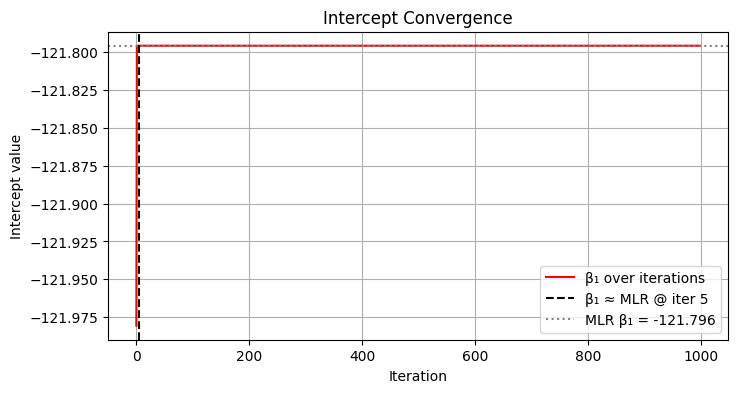

In [74]:
beta0_mlr = mlr.intercept_

# Find the iteration where β₁_hold is closest to the MLR β₁
closest_idx = np.argmin(np.abs(np.array(B0_hold) - beta0_mlr))

# Plot the coefficient evolution
plt.figure(figsize=(8, 4))
plt.plot(B0_hold, color='red', label='β₁ over iterations')
plt.axvline(x=closest_idx, color='k', linestyle='--', label=f'β₁ ≈ MLR @ iter {closest_idx}')
plt.axhline(y=beta0_mlr, color='gray', linestyle=':', label=f'MLR β₁ = {beta0_mlr:.3f}')
plt.xlabel("Iteration")
plt.ylabel("Intercept value")
plt.legend()
plt.title("Intercept Convergence")
plt.grid(True)
plt.show()

Rouhgly 5 iterations needed before its like bang onto the mlr 